In [50]:
"""
This script is suposed to produce plots of the results from
macroscopic approximation of the network-based microscopic model of divestment.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class plot_routines(object):
    """
    this contains the routines to make different plots to compare the two
    types of model description
    """

    def __init__(self, base_path):
        with pd.HDFStore(base_path + 'micro/mean.h5') as store:
            self.micro_mean = store.select('dat')
        with pd.HDFStore(base_path + 'micro/std.h5') as store:
            self.micro_sem = store.select('dat')
        with pd.HDFStore(base_path + 'mean/mean.h5') as store:
            self.macro_mean = store.select('dat')
        with pd.HDFStore(base_path + 'mean/std.h5') as store:
            self.macro_sem = store.select('dat')

        self.data_sets = [self.micro_mean, self.micro_sem,
                     self.macro_mean, self.macro_sem]

        for d in self.data_sets:
            d.index = d.index.droplevel(['approximate', 'test', 'sample'])

        self.variable_combos = [['x', 'y', 'z'], ['c', 'g'], ['mu_c^c', 'mu_d^d'],
                                ['mu_c^d', 'mu_d^c']]
        self.latex_labels = [['$x$', '$y$', '$z$'], ['$c$', '$g$'],
                             ['$\mu^{(c)}_c$', '$\mu^{(d)}_d$'],
                             ['$\mu^{(c)}_d$', '$\mu^{(d)}_c$']]

        self.colors = 'rgbk'

    def mk_plots(self, bd):

        # select data for given value of bd
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs(bd, level=0))

        phi_vals = local_datasets[0].index.levels[0].values

        l_phi = len(phi_vals)
        l_vars = len(self.variable_combos)

        fig = plt.figure()
        axes = [fig.add_subplot(l_vars, l_phi, i + 1 + j * l_phi)
                for i in range(l_phi)
                for j in range(l_vars)]

        for i, phi in enumerate(phi_vals):
            for j, variables in enumerate(self.variable_combos):
                ax_id = self.grid_index(i, j, l_phi, l_vars) - 1
                # local data set for specifiv value of phi
                ldp = []
                for d in local_datasets:
                    ldp.append(d.xs(phi, level=0))
                print(self.grid_index(i, j, l_phi, l_vars))
                ldp[0][variables]\
                    .plot(
                    ax=axes[ax_id],
                    legend=False,
                    color=self.colors)
                for k, variable in enumerate(variables):
                    upper_limit = np.transpose(ldp[0][[variable]].values \
                                  + ldp[1][[variable]].values)[0]
                    lower_limit = np.transpose(ldp[0][[variable]].values \
                                  - ldp[1][[variable]].values)[0]
                    axes[ax_id].fill_between(ldp[0].index.values,
                                     upper_limit, lower_limit,
                                     color=self.colors[k],
                                     alpha=0.2)
                    ldp[2][variables] \
                        .plot(
                        ax=axes[ax_id],
                        legend=False,
                        color=self.colors,
                        style='-.')

        return fig

    def mk_switchplots(self, bd, phi):
                # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi], level=[0, 1]))
        switchlist = np.load('switch_bd={}_phi={}.pkl'.format(bd, phi))

        fig = plt.figure()

        vars = self.variable_combos[2] + self.variable_combos[3]
        for v, var in enumerate(vars):
            direction = 1 if var[-2] == 'c' else 0
            capital_kind = '$K^{(c)}$' if var[-1] == 'c' else '$K^{(d)}$'
            print( var, capital_kind, direction)
            c1 = 'b'
            ax1 = fig.add_subplot(2, 2, v + 1)
            mu = local_datasets[0][[var]]
            emu = local_datasets[1][[var]]
            upper = np.transpose(np.array(mu.values + 2*emu.values))[0]
            lower = np.transpose(np.array(mu.values - 2*emu.values))[0]
            mu.plot(ax=ax1)
            ax1.plot(emu.index.values, upper, color=c1, alpha=0.4)
            ax1.plot(emu.index.values, lower, color=c1, alpha=0.4)
            plt.fill_between(emu.index.values,
                             upper,
                             lower,
                             color='k', alpha=0.2)
            l = len(switchlist[['direction']].values)
            ldots = 1000
            ts = []
            ks = []
            for i in range(ldots):
                k = np.random.randint(l)
                t = 1 if switchlist[['direction']].values[k] == direction else 0
                if t:
                    ts.append(switchlist.index.values[k])
                    ks.append(switchlist[[capital_kind]].values[k])
            ax1.plot(ts, ks, 'o'+c1, alpha=0.2, label=capital_kind)
            handles, labels = ax1.get_legend_handles_labels()
            ax1.legend(handles, ['$\mu_{}^{{({})}}$'.format(var[-2], var[-1]), capital_kind], loc=0)
        return fig



    def mk_4plots(self, bd, phi, eps):
        # set opacity for plots of micro data:
        micro_alpha=0.8
        # select data for given value of bd and phi
        local_datasets = []
        for d in self.data_sets:
            local_datasets.append(d.xs([bd, phi, eps], level=[0, 1, 2]))

        l_vars = len(self.variable_combos)
        fig = plt.figure(figsize=(8,6))
        axes = [fig.add_subplot(2, 2, i + 1) for i in range(l_vars)]

        legend_locations = [4, 7, 1, 7]
        upper_limits = [1., 80, 11, 10, 15]
        lower_limits = [-.8, 0., 0., 0., 0.]

        for j, variables in enumerate(self.variable_combos):
            ax_id = j
            axes[ax_id].set_xlim([0,1000])
            # local data set for specify value of phi
            ldp = local_datasets
            if j == 1:
                print( 'c exception')
                c_ax = axes[ax_id].twinx()
                ldp[0][variables[0]] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors[0],
                    alpha=micro_alpha)
                ldp[0][variables[1]] \
                    .plot(
                    ax=c_ax,
                    color=self.colors[1],
                    alpha=micro_alpha)

                c_ax.set_ylim([0, 5])
            else:
                ldp[0][variables] \
                    .plot(
                    ax=axes[ax_id],
                    color=self.colors,
                    alpha=micro_alpha)
            for k, variable in enumerate(variables):
                ax = axes[ax_id]
                if variable == 'g':
                    ax = c_ax
                    ax.set_ylim([lower_limits[-1], upper_limits[-1]])

                upper_limit = np.transpose(ldp[0][[variable]].values \
                                           + ldp[1][[variable]].values)[0]
                lower_limit = np.transpose(ldp[0][[variable]].values \
                                           - ldp[1][[variable]].values)[0]
                ax.fill_between(ldp[0].index.values,
                                         upper_limit, lower_limit,
                                         color='k',
                                         alpha=0.05)
                ax.plot(ldp[0].index.values,
                                         upper_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                ax.plot(ldp[0].index.values,
                                         lower_limit,
                                         color=self.colors[k],
                                         alpha=0.2)
                
                ldp[2][[variable]] \
                    .plot(ax=ax,
                          color=self.colors[k],
                          legend=False,
                          style='--',
                          linewidth=2
                          )

            ax = axes[ax_id]
            ax.set_ylim([lower_limits[j], upper_limits[j]])
            k = len(variables)
            patches, labels = ax.get_legend_handles_labels()
            labels = self.latex_labels[j]
            if j == 1:
                gArtist = plt.Line2D((0,1),(0,0), color=self.colors[1])
                cArtist = plt.Line2D((0,1),(0,0), color=self.colors[0])
                patches = [cArtist, gArtist]
            if j is 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            lg = ax.legend(patches[:k], labels[:k],
                           loc=legend_locations[ax_id],
                           title='',
                           fontsize=12)
            lg.get_frame().set_alpha(0.8)

            #ax.set_title('')
            #ax.set_loc

        return fig


    def grid_index(self, row, col, n_rows, n_cols):
        """
        calculate index number in subplot grids
        grid_index(0,0) = 1 ~ upper left corner
        to index the axis list, one might use grid_index - 1
        """
        return col + 1 + row * n_cols

c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception
c exception


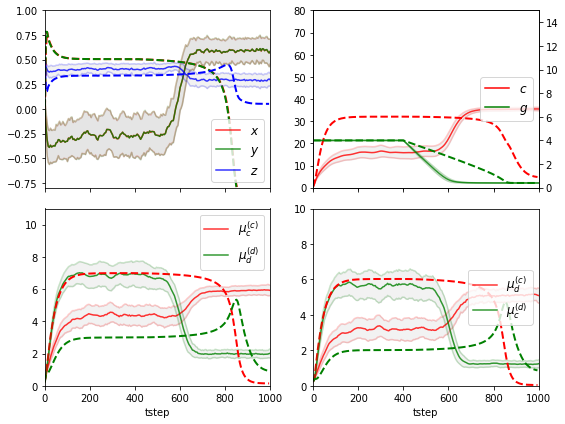

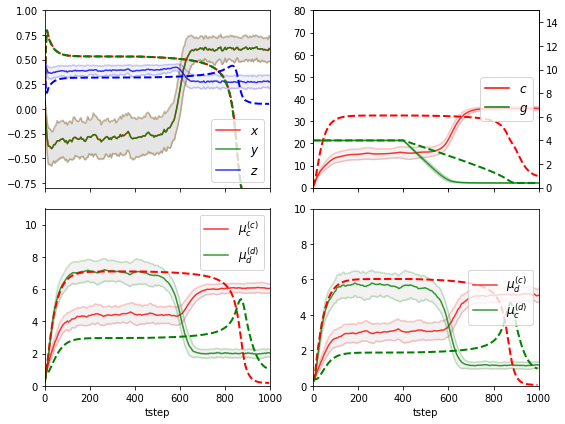

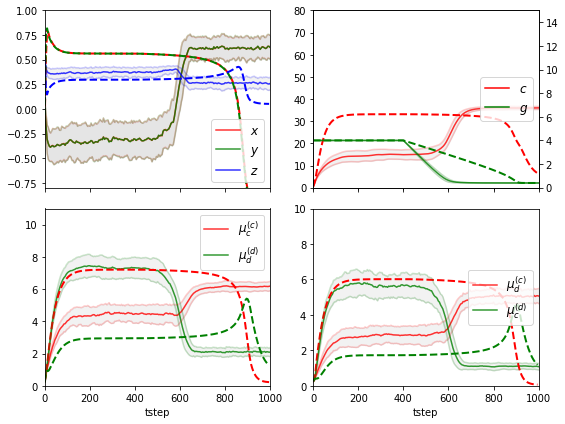

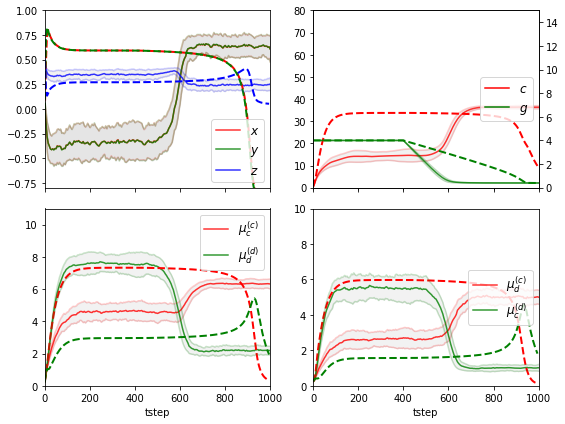

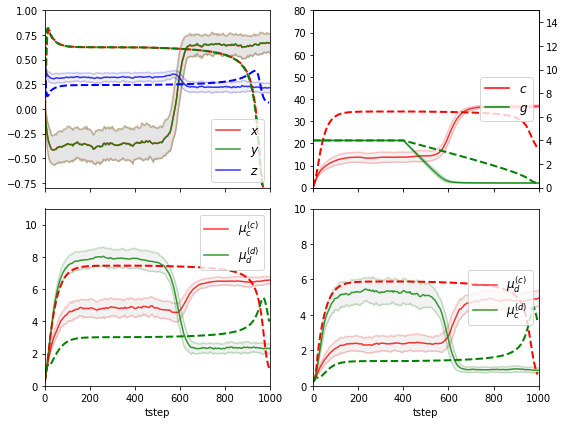

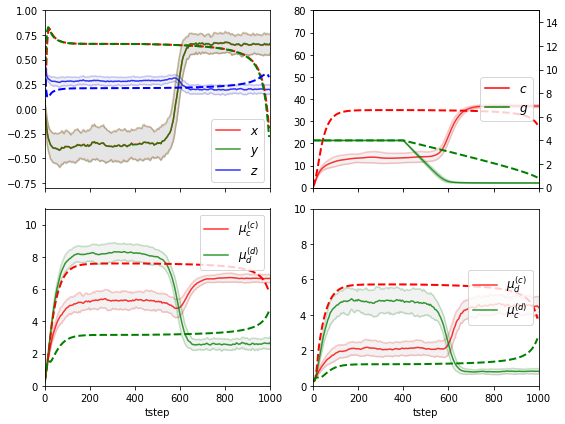

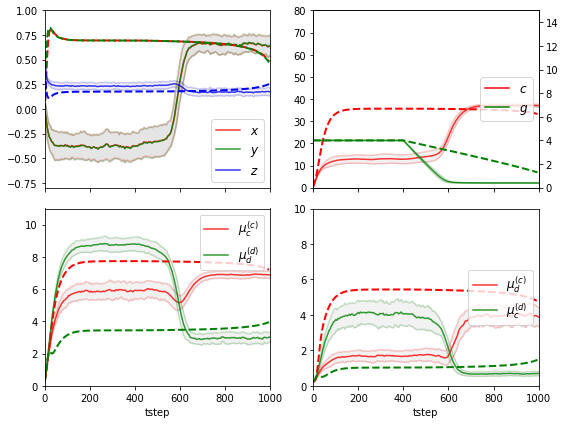

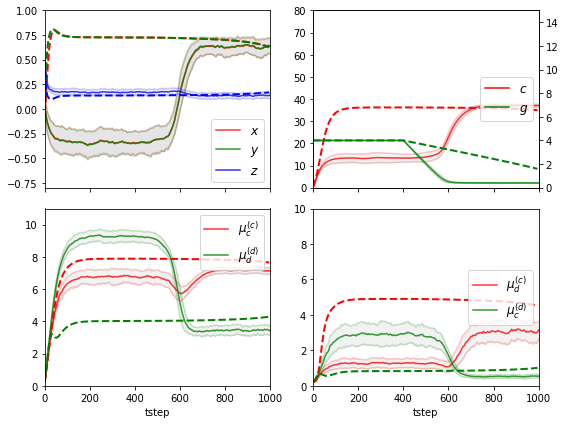

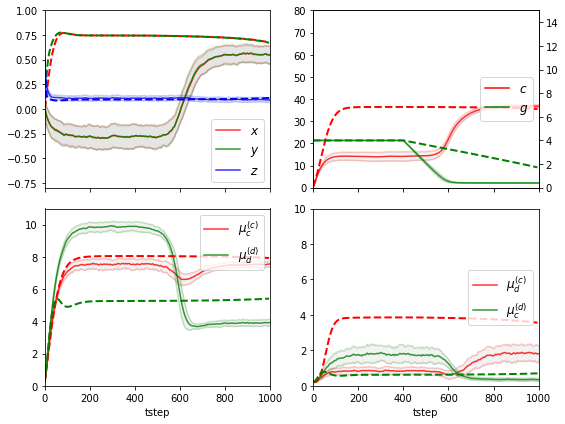

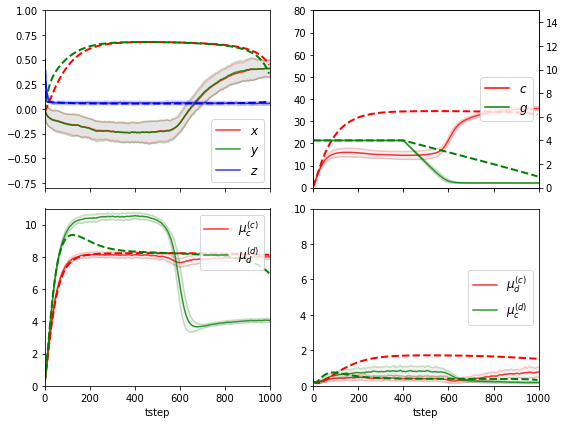

In [52]:
import time

bc, eps = 1.25, 0.05

#prt = plot_routines(base_path='/home/jakob/Project_Divestment/PyDivestment/output_data/test_output/P2/')
prt = plot_routines(base_path='/home/jakob/Project_Divestment/PyDivestment/output_data/P2/')


for phi in [round(x, 5) for x in list(np.linspace(0.0, 0.9, 10))]:
#for phi in [.1, .4, .8, 1.]:

    figure = prt.mk_4plots(bc, phi, eps)
    figure.tight_layout()
    figure.savefig('trajectory_bc={}_phi={}.pdf'.format(bc, phi))


In [41]:
prt.macro_mean.head()

W_c       W_d         c    g       i_c       k_c  \
b_d  phi eps  tstep                                                          
1.25 0.4 0.05 0.0    0.259717  0.259717  1.000000  8.0  0.470000  0.500000   
              5.0    0.349719  0.422728  3.466857  8.0  0.232001  0.870405   
              10.0   0.478873  0.555680  5.483700  8.0  0.123830  0.987630   
              15.0   0.617343  0.676346  6.708800  8.0  0.117511  1.037642   
              20.0   0.725449  0.780124  7.454283  8.0  0.139658  1.162977   

                          k_d       l_c       l_d       n_c  ...      mu_d^d  \
b_d  phi eps  tstep                                          ...               
1.25 0.4 0.05 0.0    0.500000  0.437110  0.562890  0.470000  ...    0.250000   
              5.0    1.278992  0.386021  0.613979  0.267438  ...    0.766243   
              10.0   2.590713  0.276736  0.723264  0.140923  ...    1.403805   
              15.0   4.120223  0.207833  0.792167  0.127314  ...    2.165961   
              20.0   5.609329  0.177242  0.822758  0.148619  ...    2.941307   

                            x         y         z    C    G  K_c^c  K_c^d  \
b_d  phi eps  tstep                                                         
1.25 0.4 0.05 0.0   -0.060000 -0.059944  0.500500  0.0  0.0    0.0    0.0   
              5.0   -0.465125 -0.699946  0.186183  0.0  0.0    0.0    0.0   
              10.0  -0.718155 -0.783289  0.152996  0.0  0.0    0.0    0.0   
              15.0  -0.745372 -0.736646  0.186609  0.0  0.0    0.0    0.0   
              20.0  -0.702762 -0.679480  0.218450  0.0  0.0    0.0    0.0   

                     K_d^c  K_d^d  
b_d  phi eps  tstep                
1.25 0.4 0.05 0.0      0.0    0.0  
              5.0      0.0    0.0  
              10.0     0.0    0.0  
              15.0     0.0    0.0  
              20.0     0.0    0.0  

[5 rows x 28 columns]

In [3]:
prt.micro_mean.head()

observables              Wc        Wd         c    g    mu_c^c    mu_c^d  \
b_d phi timesteps                                                          
1.0 0.0 0.0        0.224685  0.224686  0.500026  4.0  0.250010  0.249999   
        4.0        0.309225  0.303101  1.680827  4.0  0.554923  0.320228   
        8.0        0.384330  0.371613  3.052175  4.0  0.820866  0.485644   
        12.0       0.449437  0.433693  4.513931  4.0  1.096903  0.687644   
        16.0       0.506946  0.489581  6.001212  4.0  1.370611  0.898610   

observables          mu_d^c    mu_d^d       r_c       r_d  time         w  \
b_d phi timesteps                                                           
1.0 0.0 0.0        0.249999  0.250010  0.428196  0.470532   0.0  0.520740   
        4.0        0.314585  0.548185  0.364518  0.340042   4.0  0.720576   
        8.0        0.478440  0.809234  0.308525  0.274219   8.0  0.893559   
        12.0       0.661953  1.064558  0.268669  0.234078  12.0  1.046820   
        16.0       0.857461  1.321599  0.240482  0.207173  16.0  1.182798   

observables               x         y         z  
b_d phi timesteps                                
1.0 0.0 0.0        0.009700  0.010063  0.498829  
        4.0        0.003926  0.001312  0.447708  
        8.0        0.017523  0.018664  0.443912  
        12.0       0.024771  0.024190  0.440561  
        16.0       0.023961  0.023851  0.441375

In [31]:
import pandas as pd
store = pd.HDFStore('/home/jakob/Project_Divestment/PyDivestment/output_data/test_output/P2/micro/mean.h5')

In [32]:
data = store.select('dat', 'approximate = 1 & sample = 0 & eps = 0.05 & b_d = 1.25')

In [33]:
data.index = data.index.droplevel('eps').droplevel('b_d').droplevel('test').droplevel('sample').droplevel('approximate')

In [34]:
data.head()

W_c       W_d         c         g       i_c       k_c  \
phi tstep                                                               
0.4 0.000  0.259718  0.259721  1.000045  7.999999  0.506667  0.500012   
    0.015  0.259741  0.260263  1.006800  7.999999  0.507805  0.502065   
    0.030  0.259880  0.260916  1.013565  7.999999  0.506518  0.503624   
    0.045  0.260002  0.261553  1.020341  7.999999  0.506278  0.505252   
    0.060  0.260164  0.262225  1.027123  7.999999  0.504803  0.506703   

                k_d       l_c       l_d       n_c    ...        mu_d^d  \
phi tstep                                            ...                 
0.4 0.000  0.500012  0.437112  0.562888  0.506667    ...      0.250011   
    0.015  0.501993  0.437469  0.562531  0.507815    ...      0.251689   
    0.030  0.503492  0.437739  0.562261  0.506702    ...      0.253360   
    0.045  0.505074  0.438014  0.561986  0.506667    ...      0.255041   
    0.060  0.506488  0.438256  0.561744  0.505415    ...      0.256707   

                  x         y         z           C           G        Kcc  \
phi tstep                                                                    
0.4 0.000  0.013333  0.011062  0.507862  100.004498  799.999934  25.334466   
    0.015  0.015629  0.013425  0.508806  100.679974  799.999934  25.562295   
    0.030  0.013404  0.012496  0.508997  101.356519  799.999934  25.676142   
    0.045  0.013333  0.012385  0.508516  102.034091  799.999934  25.844458   
    0.060  0.010830  0.008876  0.508380  102.712339  799.999934  25.950121   

                 Kcd        Kdc        Kdd  
phi tstep                                   
0.4 0.000  24.666519  25.333181  24.667770  
    0.015  24.586990  25.367786  24.775341  
    0.030  24.621231  25.289471  24.996336  
    0.045  24.600849  25.264943  25.164040  
    0.060  24.642774  25.179861  25.392869  

[5 rows x 28 columns]